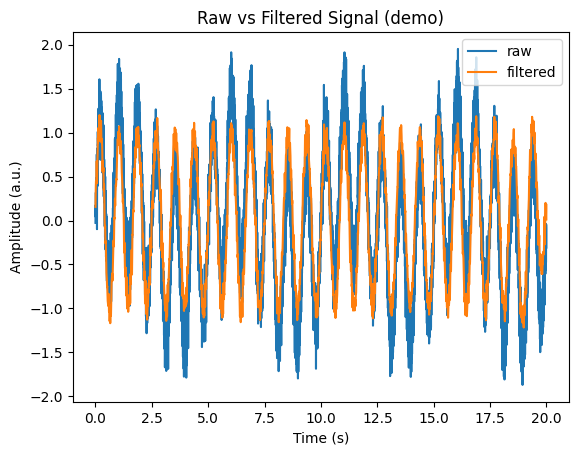

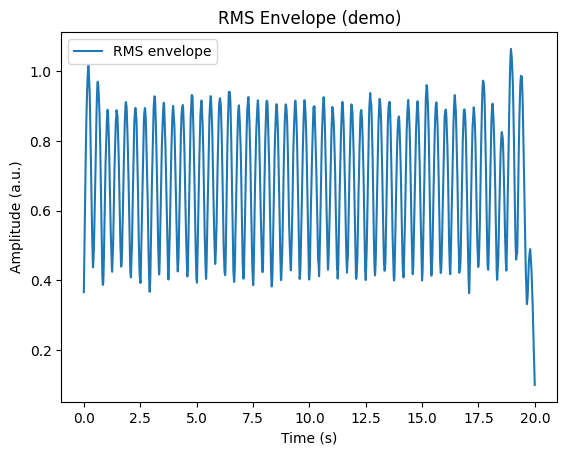

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from signal_toolkit import bandpass_filter, moving_rms

# ---- 1) Create a synthetic "biomedical-ish" signal ----
fs = 250  # Hz (common for ECG-like signals)
duration_s = 20
t = np.arange(0, duration_s, 1/fs)

# baseline wander (slow drift)
baseline = 0.5 * np.sin(2*np.pi*0.2*t)

# main rhythm component (~1.2 Hz ~ 72 bpm)
rhythm = 1.0 * np.sin(2*np.pi*1.2*t)

# higher frequency "muscle-ish" noise
muscle = 0.2 * np.sin(2*np.pi*70*t)
#muscle = 0.2 * np.sin(2*np.pi*35*t)

# random noise
noise = 0.15 * np.random.randn(len(t))

x_raw = baseline + rhythm + muscle + noise

# ---- 2) Filter it ----
# For ECG-ish: bandpass around ~0.5–40 Hz (just a demo range)
x_filt = bandpass_filter(x_raw, fs=fs, low_hz=0.5, high_hz=40, order=4)

# Optional: RMS envelope (not necessary today, but good to see)
env = moving_rms(x_filt, window_samples=int(0.2 * fs))

# ---- 3) Plot raw vs filtered (first 8 seconds) ----
N = len(t)

plt.figure()
plt.plot(t[:N], x_raw[:N], label="raw")
plt.plot(t[:N], x_filt[:N], label="filtered")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")
plt.title("Raw vs Filtered Signal (demo)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t[:N], env[:N], label="RMS envelope")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")
plt.title("RMS Envelope (demo)")
plt.legend()
plt.show()


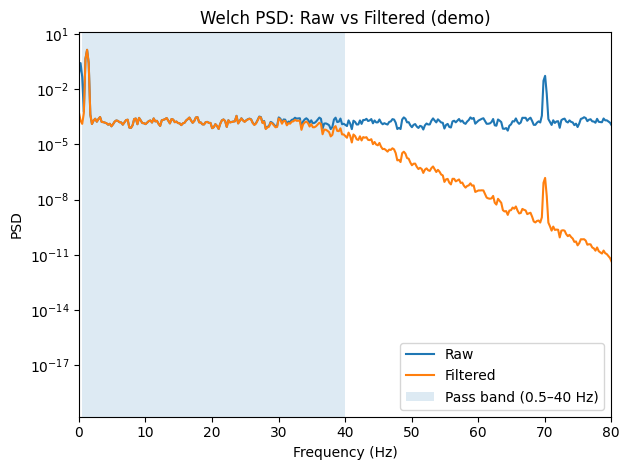

Drift/Pass ratio raw:      0.1509
Drift/Pass ratio filtered: 0.0002532
Improvement (raw/filtered): 596x


In [2]:
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt

# Welch settings (safe defaults for 20s @ 250 Hz)
nperseg = 1024
noverlap = nperseg // 2

f, P_raw = welch(x_raw, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap, scaling="density")
_, P_flt = welch(x_filt, fs=fs, window="hann", nperseg=nperseg, noverlap=noverlap, scaling="density")

def bandpower(f, P, lo, hi):
    m = (f >= lo) & (f <= hi)
    return np.trapz(P[m], f[m])

# Bands for THIS demo (match your filter)
drift_band = (0, 0.5)
pass_band  = (0.5, 40)

raw_drift = bandpower(f, P_raw, *drift_band)
raw_pass  = bandpower(f, P_raw, *pass_band)
flt_drift = bandpower(f, P_flt, *drift_band)
flt_pass  = bandpower(f, P_flt, *pass_band)

raw_ratio = raw_drift / (raw_pass + 1e-12)
flt_ratio = flt_drift / (flt_pass + 1e-12)
improv = raw_ratio / (flt_ratio + 1e-12)

plt.figure()
plt.semilogy(f, P_raw, label="Raw")
plt.semilogy(f, P_flt, label="Filtered")
plt.axvspan(*pass_band, alpha=0.15, label="Pass band (0.5–40 Hz)")
plt.xlim(0, 80)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Welch PSD: Raw vs Filtered (demo)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Drift/Pass ratio raw:      {raw_ratio:.4g}")
print(f"Drift/Pass ratio filtered: {flt_ratio:.4g}")
print(f"Improvement (raw/filtered): {improv:.3g}x")


peaks: 25
BPM: 72.7


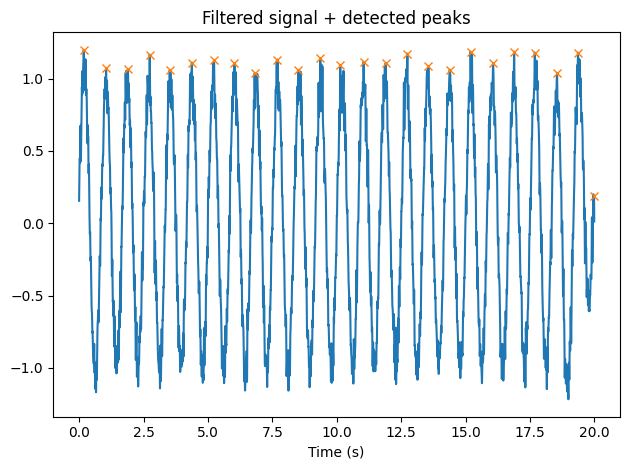

In [3]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

min_distance_s = 0.4  # prevents double counting (max ~150 bpm)
#peaks, _ = find_peaks(x_filt, distance=int(min_distance_s*fs))
peaks, _ = find_peaks(x_filt, distance=int(0.6*fs), height=0)

rr = np.diff(peaks) / fs
bpm = 60 / np.mean(rr)

print("peaks:", len(peaks))
print("BPM:", round(bpm, 1))

plt.figure()
plt.plot(t, x_filt)
plt.plot(t[peaks], x_filt[peaks], "x")
plt.title("Filtered signal + detected peaks")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


In [4]:
rr = np.diff(peaks) / fs
print("RR (s):", np.round(rr[:10], 3))
print("RR mean/std (s):", rr.mean().round(3), rr.std().round(3))


RR (s): [0.868 0.848 0.844 0.776 0.86  0.86  0.78  0.796 0.888 0.808]
RR mean/std (s): 0.825 0.054


In [5]:
from signal_toolkit import ecg_peaks_hr

peaks, rr, bpm = ecg_peaks_hr(x_filt, fs=fs, max_hr=180, prominence=0.6)
print("peaks:", len(peaks))
print("BPM:", round(bpm, 1))
print("RR mean/std (s):", round(rr.mean(), 3), round(rr.std(), 3))

peaks: 24
BPM: 71.9
RR mean/std (s): 0.834 0.035


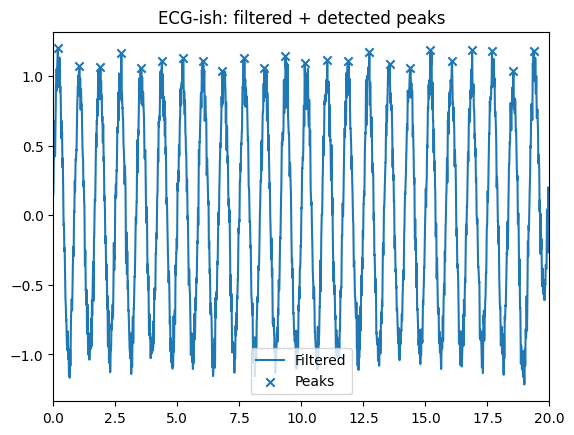

In [6]:
plt.figure()
plt.plot(t, x_filt, label ="Filtered")
plt.scatter(t[peaks], x_filt[peaks], marker="x", label="Peaks")
plt.xlim(0, 20)
plt.title("ECG-ish: filtered + detected peaks")
plt.legend()
plt.show()

In [7]:
import numpy as np
from signal_toolkit import welch_psd
fs=250
t=np.arange(0,20,1/fs)
x=np.sin(2*np.pi*1.2*t)
f,P=welch_psd(x,fs)
print(len(f), P.shape, f[np.argmax(P)])

513 (513,) 1.220703125


In [8]:
from signal_toolkit import rhythm_psd_metric
peak_hz, ratio = rhythm_psd_metric(x, fs=250)
print(peak_hz, ratio)
print("BPM from peak:", np.asarray(peak_hz) * 60)


1.220703125 0.8939524495523928
BPM from peak: 73.2421875


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

from signal_toolkit import welch_psd, rhythm_psd_metric

f, Pxx = welch_psd(x, fs=fs, nperseg=1024)
peak_hz, ratio = rhythm_psd_metric(x, fs=fs, nperseg=1024)

peak_bpm = np.asarray(peak_hz) * 60

plt.figure()
plt.semilogy(f, Pxx)
plt.axvline(float(np.asarray(peak_hz)), linestyle="--")
plt.title(f"Welch PSD | peak={float(np.asarray(peak_hz)):.4f} Hz ({float(np.asarray(peak_bpm)):.2f} BPM) | ratio={float(np.asarray(ratio)):.3f}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")

out_dir = r"D:\Study Material\LifeReset\Artifacts\signals"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "2025-12-29_psd_peak_ratio.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close()

print("Saved:", out_path)


Saved: D:\Study Material\LifeReset\Artifacts\signals\2025-12-29_psd_peak_ratio.png


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

from signal_toolkit import bandpass_filter, ecg_peaks_hr, welch_psd, rhythm_psd_metric

# ---------- Load ONE real ECG sample (SciPy dataset) ----------
x = None
fs = None

try:
    from scipy.datasets import electrocardiogram  # newer SciPy
    x = electrocardiogram().astype(float)
    fs = 360.0  # SciPy ECG dataset is typically 360 Hz
except Exception:
    try:
        from scipy.misc import electrocardiogram  # older SciPy
        x = electrocardiogram().astype(float)
        fs = 360.0
    except Exception:
        x = None

# ---------- Fallback: more realistic synthetic QRS-like waveform ----------
if x is None:
    fs = 250.0
    dur = 20.0
    t = np.arange(0, dur, 1/fs)

    # RR jittered around ~72 bpm
    rr_mean = 60/72
    rr = rr_mean + 0.03*np.sin(2*np.pi*0.1*t)
    beat_times = [0.5]
    i = 0
    while beat_times[-1] < dur - 0.5:
        beat_times.append(beat_times[-1] + rr[int(min(i, len(rr)-1))*0 + int((beat_times[-1]*fs) % len(rr))])
        i += 1

    # QRS template: sum of Gaussians (P, Q, R, S, T)
    def gauss(tt, mu, sigma, amp):
        return amp*np.exp(-0.5*((tt-mu)/sigma)**2)

    x = np.zeros_like(t)
    for bt in beat_times:
        x += gauss(t, bt-0.18, 0.03, 0.15)   # P
        x += gauss(t, bt-0.02, 0.008, -0.25) # Q
        x += gauss(t, bt,      0.010, 1.00)  # R
        x += gauss(t, bt+0.02, 0.010, -0.35) # S
        x += gauss(t, bt+0.25, 0.060, 0.35)  # T

    # baseline wander + noise
    x += 0.15*np.sin(2*np.pi*0.2*t) + 0.03*np.random.randn(len(t))

# ---------- Take a 20s segment ----------
seg_s = 20
start_sec = 0  # change if you want a different region
i0 = int(start_sec * fs)
i1 = i0 + int(seg_s * fs)
x_seg = x[i0:i1]

# ---------- Filter + peaks ----------
x_filt = bandpass_filter(x_seg, fs=fs, low_hz=0.5, high_hz=40.0, order=4)

peaks, rr_sec, bpm = ecg_peaks_hr(x_filt, fs=fs, max_hr=180, prominence=0.6)

print("fs:", fs, "Hz | segment:", seg_s, "s")
print("peaks:", len(peaks))
print("BPM:", round(float(bpm), 1))
print("RR mean/std (s):", round(float(rr_sec.mean()), 3), round(float(rr_sec.std()), 3))

# ---------- PSD metric ----------
peak_hz, ratio = rhythm_psd_metric(x_filt, fs=fs, nperseg=1024)
print("PSD peak (Hz):", float(np.asarray(peak_hz)))
print("PSD ratio:", float(np.asarray(ratio)))

# ---------- Save plot (signal + peaks, PSD) ----------
out_dir = r"..\Artifacts\signals"
os.makedirs(out_dir, exist_ok=True)

date_tag = "2026-01-05"
out_path = os.path.join(out_dir, f"{date_tag}_realpass_ecg_peaks_psd.png")

t = np.arange(len(x_filt)) / fs

# Signal plot
plt.figure()
plt.plot(t, x_filt)
plt.plot(t[peaks], x_filt[peaks], "o")
plt.title(f"ECG real-pass | BPM={float(bpm):.1f} | RR={float(rr_sec.mean()):.3f}±{float(rr_sec.std()):.3f}s")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.close()

# PSD plot (separate file)
f, Pxx = welch_psd(x_filt, fs=fs, nperseg=1024)
out_path_psd = os.path.join(out_dir, f"{date_tag}_realpass_psd.png")

plt.figure()
plt.semilogy(f, Pxx)
plt.axvline(float(np.asarray(peak_hz)), linestyle="--")
plt.title(f"Welch PSD | peak={float(np.asarray(peak_hz)):.4f} Hz ({float(np.asarray(peak_hz))*60:.2f} BPM) | ratio={float(np.asarray(ratio)):.3f}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.savefig(out_path_psd, dpi=200, bbox_inches="tight")
plt.close()

print("Saved:", out_path)
print("Saved:", out_path_psd)


C:\Users\auniy\AppData\Local\Temp\ipykernel_28256\3848407797.py:18: DeprecationWarning: scipy.misc.electrocardiogram has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.electrocardiogram instead.
  x = electrocardiogram().astype(float)


fs: 360.0 Hz | segment: 20 s
peaks: 39
BPM: 118.4
RR mean/std (s): 0.507 0.04
PSD peak (Hz): 1.7578125
PSD ratio: 0.05648436921414548
Saved: ..\Artifacts\signals\2026-01-05_realpass_ecg_peaks_psd.png
Saved: ..\Artifacts\signals\2026-01-05_realpass_psd.png


ENV peaks: 21
BPM: 61.4 | RR mean/std (s): 0.977 0.364
BPM filtered: 68.2 | RRf mean/std (s): 0.88 0.306 | kept: 17 / 20


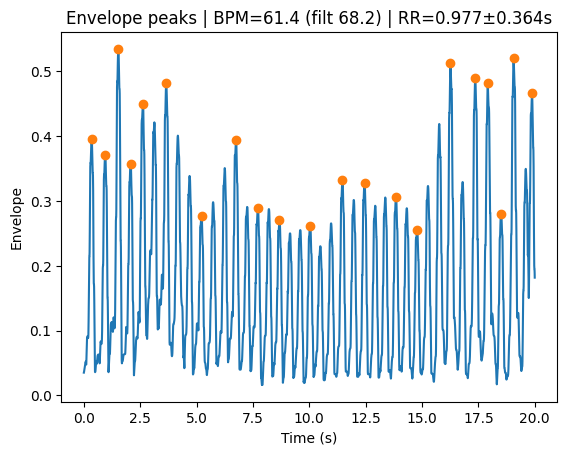

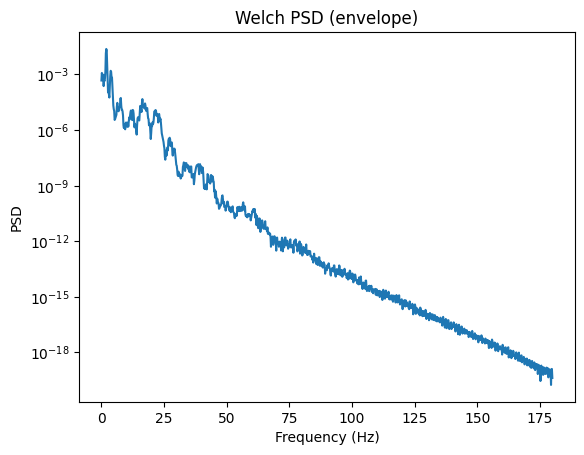

Envelope PSD peak: 1.93359375 Hz | BPM: 116.015625
Envelope PSD fundamental: 1.93359375 Hz | BPM: 116.015625


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from signal_toolkit import bandpass_filter, moving_rms, welch_psd

# 1) Detection signal: isolate QRS-ish energy (suppresses T-waves)
x_qrs = bandpass_filter(x_seg, fs=fs, low_hz=5.0, high_hz=15.0, order=4)

# 2) Envelope: rectify + smooth
win = int(0.15 * fs)  # 150 ms
x_env = moving_rms(np.abs(x_qrs), window_samples=win)

# 3) Peaks on envelope with stricter spacing
max_hr = 110
min_dist = int(fs * 60 / max_hr)
prom = 0.5 * np.std(x_env)

peaks, props = find_peaks(x_env, distance=min_dist, prominence=prom)

# 4) HR from envelope peaks (raw + filtered RR)
rr_sec = np.diff(peaks) / fs
bpm = 60.0 / rr_sec.mean()

rr_med = np.median(rr_sec)
keep = (rr_sec > 0.5 * rr_med) & (rr_sec < 1.5 * rr_med)
rr_sec_f = rr_sec[keep]
bpm_f = 60.0 / rr_sec_f.mean()

print("ENV peaks:", len(peaks))
print("BPM:", round(float(bpm), 1), "| RR mean/std (s):", round(float(rr_sec.mean()), 3), round(float(rr_sec.std()), 3))
print("BPM filtered:", round(float(bpm_f), 1), "| RRf mean/std (s):", round(float(rr_sec_f.mean()), 3), round(float(rr_sec_f.std()), 3),
      "| kept:", int(keep.sum()), "/", len(rr_sec))

# Plot envelope + peaks
t = np.arange(len(x_env)) / fs
plt.figure()
plt.plot(t, x_env)
plt.plot(t[peaks], x_env[peaks], "o")
plt.title(f"Envelope peaks | BPM={bpm:.1f} (filt {bpm_f:.1f}) | RR={rr_sec.mean():.3f}±{rr_sec.std():.3f}s")
plt.xlabel("Time (s)")
plt.ylabel("Envelope")
plt.show()

# 5) PSD on envelope (one computation)
f, Pxx = welch_psd(x_env, fs=fs, nperseg=2048)

plt.figure()
plt.semilogy(f, Pxx)
plt.title("Welch PSD (envelope)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.show()

# PSD peak (naive) in 0.8–2.5 Hz
band = (f >= 0.8) & (f <= 2.5)
peak_hz = f[band][np.argmax(Pxx[band])]
print("Envelope PSD peak:", float(peak_hz), "Hz | BPM:", float(peak_hz * 60))

# FUNDAMENTAL: lowest-frequency prominent peak in 0.8–2.0 Hz
band2 = (f >= 0.8) & (f <= 2.0)
fb = f[band2]
Pb = Pxx[band2]

pk, _ = find_peaks(Pb, prominence=np.max(Pb) * 0.05)
if len(pk) == 0:
    fund_hz = fb[np.argmax(Pb)]
else:
    fund_hz = fb[pk[0]]

print("Envelope PSD fundamental:", float(fund_hz), "Hz | BPM:", float(fund_hz * 60))
